In [23]:
# 1. Authenticate
from google.colab import auth
auth.authenticate_user()
print('Authenticated Successfully')

# 2. Import Libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np

# 3. Initialize the client
project_id = 'pp26-488519'
client = bigquery.Client(project=project_id)

# 4. Pull the data
sql = """
SELECT * FROM `pp26-488519.gld_price.v_gold_risk_analysis`
ORDER BY Market_Date ASC
"""

df = client.query(sql).to_dataframe()
df['Market_Date'] = pd.to_datetime(df['Market_Date'])
df.head()

Authenticated Successfully


,Market_Date,Gold_USD,Silver_USD,Sp500_index,Oil_USD,EUR_USD_Rate,Gold_Log_Return,SPX_Log_Return,Gold_Silver_Ratio,Gold_30d_Vol,Market_Regime
0,2015-01-05,115.800003,15.50,2020.579956,150.320007,1.194643,0.014965,-0.018447,7.47,NaN,Hedge Behavior
1,2015-01-06,117.120003,15.83,2002.609985,144.399994,1.193902,0.011334,-0.008933,7.40,0.0026,Hedge Behavior
2,2015-01-07,116.430000,15.85,2025.900024,146.960007,1.187536,-0.005909,0.011563,7.35,0.0112,Normal
3,2015-01-08,115.940002,15.64,2062.139893,148.399994,1.183600,-0.004217,0.017730,7.41,0.0106,Normal
4,2015-01-09,117.260002,15.77,2044.810059,146.240005,1.179607,0.011321,-0.008439,7.44,0.0098,Hedge Behavior


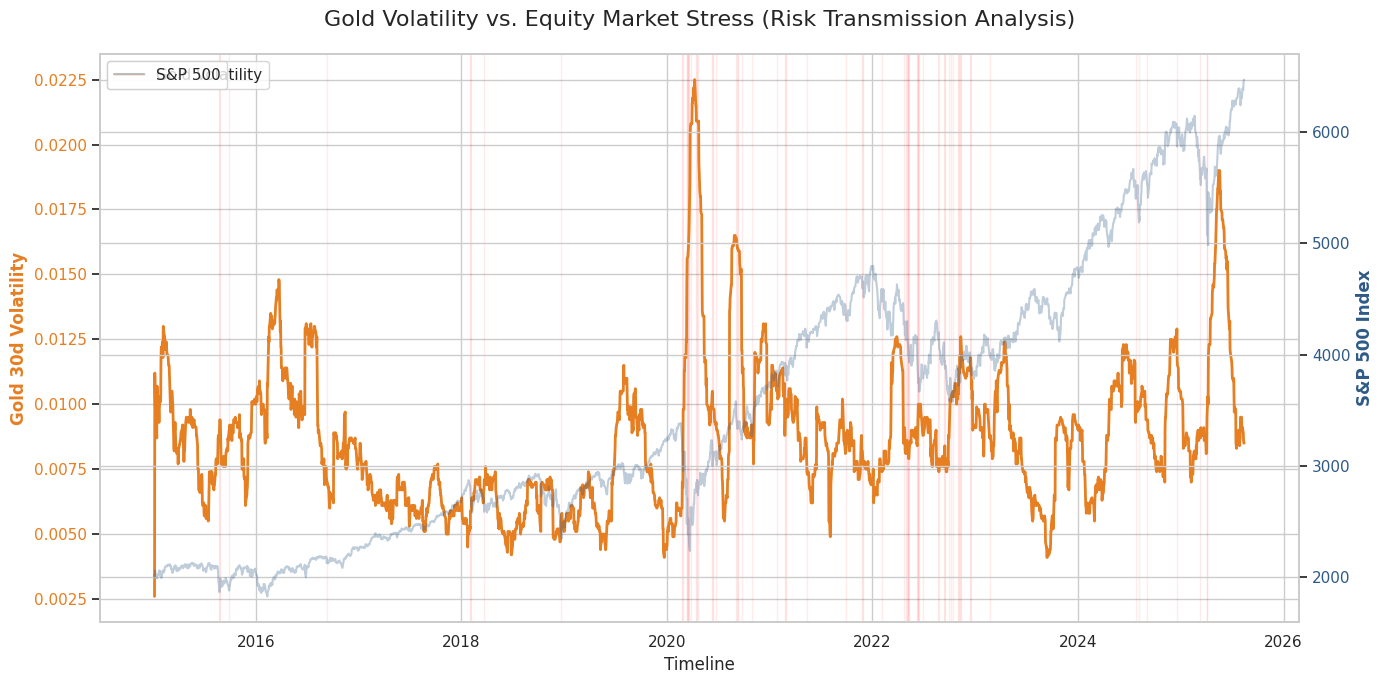

------------------------------------------------------------
OVERALL CORRELATION (Gold vs S&P 500): 0.0454
------------------------------------------------------------
REGIME PERFORMANCE SUMMARY (Based on GBQ Regimes)
        Regime  Day_Count  Avg_Gold_Ret  Gold_Risk_Std  Avg_SPX_Ret
 Equity Stress         50     -0.009843       0.007858    -0.033738
Hedge Behavior        655      0.006875       0.006246    -0.007068
        Normal       1960     -0.001541       0.008787     0.003807
------------------------------------------------------------
Insight: Gold acted as a Safe Haven on 655 specific days.


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Plotting Setup ---
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# --- 2. Plotting Gold Volatility (The Risk Signal from GBQ) ---
color_vol = '#E67E22' # Deep Orange
ax1.set_xlabel('Timeline', fontsize=12)
ax1.set_ylabel('Gold 30d Volatility', color=color_vol, fontsize=12, fontweight='bold')
sns.lineplot(data=df, x='Market_Date', y='Gold_30d_Vol', color=color_vol, ax=ax1, linewidth=2, label='Gold Volatility')
ax1.tick_params(axis='y', labelcolor=color_vol)

# --- 3. Plotting S&P 500 (The Market Benchmark) ---
ax2 = ax1.twinx()
color_spx = '#2E5A88' # Professional Blue
ax2.set_ylabel('S&P 500 Index', color=color_spx, fontsize=12, fontweight='bold')
sns.lineplot(data=df, x='Market_Date', y='Sp500_index', color=color_spx, ax=ax2, alpha=0.3, label='S&P 500')
ax2.tick_params(axis='y', labelcolor=color_spx)

# --- 4. Highlighting Equity Stress Periods ---
# Shading areas where GBQ flagged 'Equity Stress'
stress_dates = df[df['Market_Regime'] == 'Equity Stress']['Market_Date']
for date in stress_dates:
    ax1.axvspan(date, date + pd.Timedelta(days=1), color='red', alpha=0.08)

# --- 5. Finishing Touches ---
plt.title('Gold Volatility vs. Equity Market Stress (Risk Transmission Analysis)', fontsize=16, pad=20)
fig.tight_layout()
plt.savefig('gold_vs_spx_risk_analysis.png', dpi=300)
plt.show()

# --- 6. STATISTICAL ANALYSIS & SUMMARY TABLE ---
# Correlation using GBQ engineered columns
correlation = df['Gold_Log_Return'].corr(df['SPX_Log_Return'])

print("-" * 60)
print(f"OVERALL CORRELATION (Gold vs S&P 500): {correlation:.4f}")
print("-" * 60)

# Regime Performance Summary
regime_stats = df.groupby('Market_Regime').agg({
    'Gold_Log_Return': ['count', 'mean', 'std'],
    'SPX_Log_Return': ['mean']
}).reset_index()

# Flattening multi-index columns for readability
regime_stats.columns = ['Regime', 'Day_Count', 'Avg_Gold_Ret', 'Gold_Risk_Std', 'Avg_SPX_Ret']

print("REGIME PERFORMANCE SUMMARY (Based on GBQ Regimes)")
print(regime_stats.to_string(index=False))
print("-" * 60)

# Logic Check: Hedge Behavior Insight
hedge_days = len(df[df['Market_Regime'] == 'Hedge Behavior'])
print(f"Insight: Gold acted as a Safe Haven on {hedge_days} specific days.")